A few references:

* [ARVIZ API](https://python.arviz.org/en/latest/api/index.html)
* [PYMC API](https://www.pymc.io/projects/docs/en/stable/api.html)
* [xarray API](https://docs.xarray.dev/en/stable/api.html)
* [daft](https://docs.daft-pgm.org/en/latest/): &nbsp; [daft & complete pooling](https://www.tensorflow.org/probability/examples/Multilevel_Modeling_Primer#41_complete_pooling_model)
* [graphviz](https://graphviz.readthedocs.io/en/stable/api.html): &nbsp; [pymc.model_to_graphviz](https://www.pymc.io/projects/docs/en/stable/api/generated/pymc.model_to_graphviz.html), <a href="https://www.pymc.io/projects/docs/en/stable/_modules/pymc/model_graph.html#:~:text=VarName%22%2C%20str)%0A%0A%0Aclass-,ModelGraph,-%3A%0A%20%20%20%20def%20__init__(self"> pymc.model_graph.ModelGraph</a>

<br>

# Preliminaries

In [1]:
!python --version

Python 3.8.13


<br>

## Environment

In [2]:
import os
import pathlib

<br>

Set path

In [3]:
os.chdir(path=str(pathlib.Path(os.getcwd()).parent))
os.getcwd()

'J:\\library\\plausibilities\\delineating'

<br>

## Libraries

In [4]:
%matplotlib inline

In [5]:
import logging
import collections

import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

import numpy as np
import pandas as pd
import seaborn as sns

import arviz as az
import pymc as pm
import xarray as xr
import aesara.tensor as at
import graphviz

<br>

Versions

In [6]:
az.__version__

'0.13.0'

In [7]:
pm.__version__

'4.3.0'

In [8]:
np.__version__

'1.22.3'

<br>

## Custom

In [9]:
import src.graphics.settings
import src.graphics.sketch
import src.graphics.models

import src.data.radioactivity
import src.data.features
import src.data.coordinates

import src.models.complete
import src.models.unpooled
import src.models.partial
import src.models.vi

import src.models.inference
import src.models.mapping


<br>

Aesthetics

In [10]:
settings = src.graphics.settings.Settings()

settings.layout()
settings.aesthetics()

<br>

For diagrams/figures
* The `Labels` class is for `sketch.annotation(ax, Labels(title='...', xlabel='...', ylabel='...'))`

In [11]:
sketch = src.graphics.sketch.Sketch()
Labels = collections.namedtuple(typename='Labels', field_names=['title', 'xlabel', 'ylabel'])

<br>

For the DAG (directed acyclic graph) of models

In [12]:
path = os.path.join(os.getcwd(), 'notebooks')
dag = src.graphics.models.Models(path=path)

<br>

## Settings

Seed

In [13]:
RANDOM_SEED = 8924

<br>

Graphing

In [14]:
az.style.use('arviz-darkgrid')

<br>

## Logging

In [15]:
logging.basicConfig(level=logging.INFO, 
                    format='\n%(message)s\n%(asctime)s.%(msecs)03d\n', 
                    datefmt='%Y-%m-%d %H:%M:%S')
logger = logging.getLogger(__name__)

<br>
<br>

# Data

Excerpt: Focusing on Minnesota, MN, dwellings.

In [16]:
excerpt = src.data.radioactivity.Radioactivity().exc(state='MN')
logger.info(excerpt.columns)
logger.info(f'# of instances: {excerpt.shape}')
logger.info(f"# of unique codes: {excerpt['idnum'].unique().shape}")


Index(['idnum', 'state', 'state2', 'stfips', 'zip', 'region', 'typebldg',
       'floor', 'room', 'basement', 'windoor', 'rep', 'stratum', 'wave',
       'starttm', 'stoptm', 'startdt', 'stopdt', 'activity', 'pcterr', 'adjwt',
       'dupflag', 'zipflag', 'cntyfips', 'county', 'fips', 'Uppm'],
      dtype='object')
2022-12-01 14:28:26.121


# of instances: (919, 27)
2022-12-01 14:28:26.122


# of unique codes: (919,)
2022-12-01 14:28:26.124



<br>

Extra features

In [17]:
excerpt = src.data.features.Features().exc(data=excerpt)
logger.info(excerpt.columns)
logger.info(f'# of instances: {excerpt.shape}')
logger.info(f"# of unique codes: {excerpt['idnum'].unique().shape}")


Index(['idnum', 'state', 'state2', 'stfips', 'zip', 'region', 'typebldg',
       'floor', 'room', 'basement', 'windoor', 'rep', 'stratum', 'wave',
       'starttm', 'stoptm', 'startdt', 'stopdt', 'activity', 'pcterr', 'adjwt',
       'dupflag', 'zipflag', 'cntyfips', 'county', 'fips', 'Uppm', 'ln_radon',
       'countyindex'],
      dtype='object')
2022-12-01 14:28:26.164


# of instances: (919, 29)
2022-12-01 14:28:26.166


# of unique codes: (919,)
2022-12-01 14:28:26.167



<br>

Frequencies

In [18]:
frequencies = excerpt[['county', 'countyindex', 'floor']].groupby(by=['county', 'countyindex', 'floor'], sort=False).value_counts()
frequencies.rename('N', inplace=True)
frequencies = frequencies.to_frame()
frequencies.reset_index(drop=False, inplace=True)
logger.info(frequencies.head())


   county  countyindex  floor   N
0  AITKIN            0      0   3
1  AITKIN            0      1   1
2   ANOKA            1      0  49
3   ANOKA            1      1   3
4  BECKER            2      0   1
2022-12-01 14:28:26.191



<br>
<br>

# Exploratory Graphs

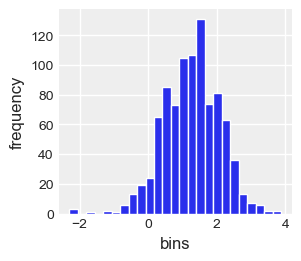

In [19]:
ax = sketch.figure(width=2.9, height=2.5)
ax.hist(excerpt.ln_radon, bins=25)
sketch.annotation(ax, Labels(title='', xlabel='bins', ylabel='frequency'))

<br>
<br>

# Models

The model's initial co$\ddot{o}$rdinates

In [20]:
coords = src.data.coordinates.Coordinates(data=excerpt).exc()
logger.info(coords)


{'Level': {'Basement': 0, 'Ground': 1}, 'County': {'AITKIN': 0, 'ANOKA': 1, 'BECKER': 2, 'BELTRAMI': 3, 'BENTON': 4, 'BIG STONE': 5, 'BLUE EARTH': 6, 'BROWN': 7, 'CARLTON': 8, 'CARVER': 9, 'CASS': 10, 'CHIPPEWA': 11, 'CHISAGO': 12, 'CLAY': 13, 'CLEARWATER': 14, 'COOK': 15, 'COTTONWOOD': 16, 'CROW WING': 17, 'DAKOTA': 18, 'DODGE': 19, 'DOUGLAS': 20, 'FARIBAULT': 21, 'FILLMORE': 22, 'FREEBORN': 23, 'GOODHUE': 24, 'HENNEPIN': 25, 'HOUSTON': 26, 'HUBBARD': 27, 'ISANTI': 28, 'ITASCA': 29, 'JACKSON': 30, 'KANABEC': 31, 'KANDIYOHI': 32, 'KITTSON': 33, 'KOOCHICHING': 34, 'LAC QUI PARLE': 35, 'LAKE': 36, 'LAKE OF THE WOODS': 37, 'LE SUEUR': 38, 'LINCOLN': 39, 'LYON': 40, 'MAHNOMEN': 41, 'MARSHALL': 42, 'MARTIN': 43, 'MCLEOD': 44, 'MEEKER': 45, 'MILLE LACS': 46, 'MORRISON': 47, 'MOWER': 48, 'MURRAY': 49, 'NICOLLET': 50, 'NOBLES': 51, 'NORMAN': 52, 'OLMSTED': 53, 'OTTER TAIL': 54, 'PENNINGTON': 55, 'PINE': 56, 'PIPESTONE': 57, 'POLK': 58, 'POPE': 59, 'RAMSEY': 60, 'REDWOOD': 61, 'RENVILLE': 62, 

<br>
<br>

## Complete

Add more notes:

* A simple linear regression model: an intercept, a gradient whereby the accompanying independent variable is *dwelling level*, i.e., basement or ground level.
* The dependent variable is *ln(radon)*
* Is the *intercept* implicit below?



<br>

### Model


The model

In [21]:
complete = src.models.complete.Complete(coords=coords, seed=RANDOM_SEED).exc(data=excerpt)


The # of level group elements: (2,)
2022-12-01 14:28:28.534


The shape of mu, whereby mu = measures[levelcode]: (919,)
2022-12-01 14:28:28.578


y
2022-12-01 14:28:28.609



<br>

An illustration of model

* Similarly: `pm.model_to_graphviz(complete)`

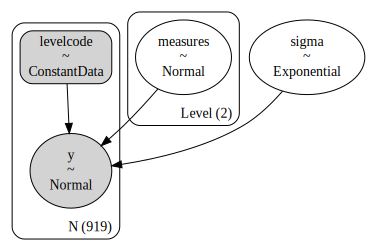

In [22]:
name = 'complete.gv'
dag.exc(model=complete, name=name)
graphviz.Source.from_file(filename=os.path.join(path, name))

<br>
<br>

### Inference

* `inferences.keys()`

* `inferences.get('prior').keys()`


In [23]:
complete_ = src.models.inference.Inference(model=complete).exc()

Auto-assigning NUTS sampler...

Auto-assigning NUTS sampler...
2022-12-01 14:28:29.841

Initializing NUTS using jitter+adapt_diag...

Initializing NUTS using jitter+adapt_diag...
2022-12-01 14:28:29.843

Multiprocess sampling (4 chains in 4 jobs)

Multiprocess sampling (4 chains in 4 jobs)
2022-12-01 14:28:33.305

NUTS: [measures, sigma]

NUTS: [measures, sigma]
2022-12-01 14:28:33.307



Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 31 seconds.

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 31 seconds.
2022-12-01 14:29:04.211

Sampling: [measures, sigma, y]

Sampling: [measures, sigma, y]
2022-12-01 14:29:10.207

Sampling: [y]

Sampling: [y]
2022-12-01 14:29:10.369



In [24]:
complete_ = src.models.mapping.Mapping(inferences=complete_, coords=coords).exc()

In [25]:
complete_

Inference data with groups:
	> posterior
	> posterior_predictive
	> log_likelihood
	> sample_stats
	> prior
	> prior_predictive
	> observed_data
	> constant_data

<br>
<br>

### Prior Measures

<br>

**Prior Measures: Distributions**



In [26]:
computations = []

for k, v in coords['Level'].items():
    
    points = complete_.prior['measures'].sel(Level=k).squeeze()
    
    instances = pd.DataFrame(data={'measures': points, 'level': np.repeat(v, points.shape[0]), 'type': np.repeat(k, points.shape[0])})
    
    computations.append(instances)

instances = pd.concat(computations, axis=0, ignore_index=True)

logger.info(instances.head())


    measures  level      type
0  11.085938      0  Basement
1  -8.154753      0  Basement
2   0.212480      0  Basement
3  18.950250      0  Basement
4  -7.250038      0  Basement
2022-12-01 14:29:11.395



<br>

The graph

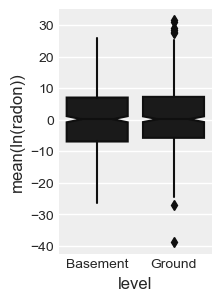

In [27]:
ax = sketch.figure(width=2.1, height=2.9)
sns.boxplot(data=instances, x='type', y='measures', notch=True, color='k', showcaps=False, ax=ax)
sketch.annotation(ax, Labels(title='', xlabel='level', ylabel='mean(ln(radon))'))

<br>
<br>

### Prior Predictive

In [28]:
complete_.prior_predictive

<xarray.Dataset>
Dimensions:  (chain: 1, draw: 500, N: 919)
Coordinates:
  * chain    (chain) int32 0
  * draw     (draw) int32 0 1 2 3 4 5 6 7 8 ... 492 493 494 495 496 497 498 499
  * N        (N) int32 0 1 2 3 4 5 6 7 8 ... 910 911 912 913 914 915 916 917 918
Data variables:
    y        (chain, draw, N) float64 2.8 12.78 11.5 ... 0.4711 -2.967 -1.535
Attributes:
    created_at:                 2022-12-01T14:29:10.325752
    arviz_version:              0.13.0
    inference_library:          pymc
    inference_library_version:  4.3.0

<br>
<br>

### Posterior Measures


Notes/references:

* [About `arviz.hdi(.)`](https://arviz-devs.github.io/arviz/api/generated/arviz.hdi.html)

* [About `xarray.DataArray`](https://docs.xarray.dev/en/stable/generated/xarray.DataArray.html#xarray.DataArray)

* [xarray.DataArray.groupy](https://docs.xarray.dev/en/stable/generated/xarray.DataArray.groupby.html#xarray.DataArray.groupby)

* cf. `trace.constant_data['level']` & `trace.constant_data['N']`


<br>

**Posterior Measures: Distributions**

In [29]:
computations = []

for k, v in coords['Level'].items():
    
    points = complete_.posterior['measures'].mean(dim=('chain')).sel(Level=k).squeeze()
    
    instances = pd.DataFrame(data={'measures': points, 'level': np.repeat(v, points.shape[0]), 'type': np.repeat(k, points.shape[0])})
    
    computations.append(instances)

instances = pd.concat(computations, axis=0, ignore_index=True)

logger.info(instances.tail())


      measures  level    type
1995  0.739547      1  Ground
1996  0.831912      1  Ground
1997  0.762413      1  Ground
1998  0.819073      1  Ground
1999  0.787851      1  Ground
2022-12-01 14:29:11.881



<br>

The distributions

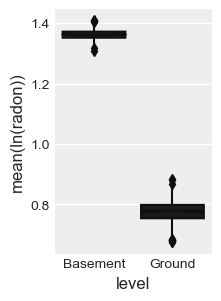

In [30]:
ax = sketch.figure(width=2.1, height=2.9)
sns.boxplot(data=instances, x='type', y='measures', notch=True, color='k', showcaps=False, ax=ax)
sketch.annotation(ax, Labels(title='', xlabel='level', ylabel='mean(ln(radon))'))

<br>
<br>

**Posterior Measures & Standard Deviations: Summaries**

In [31]:
az.summary(complete_)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
measures[Basement],1.363,0.029,1.311,1.417,0.000,0.000,5002.0,3249.0,1.0
measures[Ground],0.777,0.067,0.653,0.901,0.001,0.001,6415.0,2732.0,1.0
sigma,0.791,0.019,0.756,0.827,0.000,0.000,5864.0,2761.0,1.0


<br>
<br>

**Posterior Measures & Standard Deviations: Graphs**

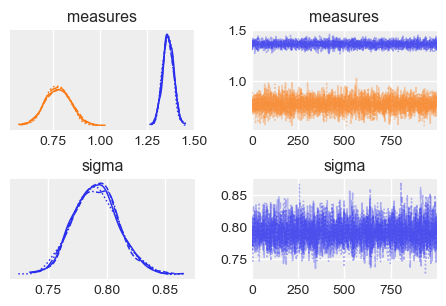

In [32]:
with complete:
    az.plot_trace(data=complete_, figsize=(4.35, 2.95))

<br>

Cf.

array([<matplotlib.axes._subplots.AxesSubplot object at 0x00000000137E6580>,
      dtype=object)

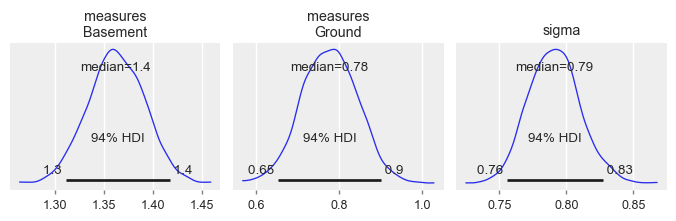

In [33]:
pm.plot_posterior(data=complete_, var_names=['measures', 'sigma'], 
                 figsize=(6.65, 2.1), grid=(1, 3), point_estimate='median', textsize=9)

<br>
<br>

**Posterior Measures Mean**

In [34]:
averages_features = complete_.posterior.mean(dim=('chain', 'draw'))
averages_features

<xarray.Dataset>
Dimensions:    (Level: 2, LevelCode: 2)
Coordinates:
  * Level      (Level) <U8 'Basement' 'Ground'
  * LevelCode  (LevelCode) int32 0 1
Data variables:
    measures   (Level) float64 1.363 0.7768
    sigma      float64 0.7911

<br>

**Posterior Measures High Density Intervals**

Herein, determining the high density posterior intervals via

> ```python
hdi_features = (
    trace.posterior['measures'].groupby(trace.posterior.LevelName).apply(
        lambda x: az.hdi(x, input_core_dims=[['chain', 'draw']]))['measures']
)
hdi_features


is unnecessarily complex, and the resulting object does not include `LevelCode` co$\ddot{o}$rdinates.

<br>


In [35]:
hdi_features = az.hdi(complete_)
hdi_features

<xarray.Dataset>
Dimensions:    (Level: 2, hdi: 2, LevelCode: 2)
Coordinates:
  * Level      (Level) <U8 'Basement' 'Ground'
  * LevelCode  (LevelCode) int32 0 1
  * hdi        (hdi) <U6 'lower' 'higher'
Data variables:
    measures   (Level, hdi) float64 1.311 1.417 0.6525 0.9013
    sigma      (hdi) float64 0.7557 0.8274

<br>
<br>

### Posterior Predictive

<br>

**Posterior Predictive Check**

Equivalent:
> ```python 
pm.plot_ppc(data=..., figsize=(2.9, 2.4), num_pp_samples=125, 
            random_seed=RANDOM_SEED, textsize=10)

> ```python 
az.plot_ppc(data=..., figsize=(2.9, 2.4), num_pp_samples=125, 
            random_seed=RANDOM_SEED, textsize=10)

<br>

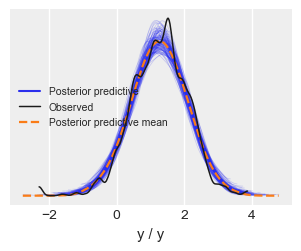

In [36]:
az.plot_ppc(data=complete_, figsize=(2.9, 2.4), num_pp_samples=125, random_seed=RANDOM_SEED, textsize=10)

<br>
<br>

**The posterior predictive high density interval per floor level type**

In [37]:
credibility = lambda x: az.hdi(x, input_core_dims=[["chain", "draw", "N"]])
hdi_predictive = (
    complete_.posterior_predictive.y.groupby(complete_.constant_data.levelcode)
    .apply(credibility)
    .y
)
hdi_predictive

<xarray.DataArray 'y' (levelcode: 2, hdi: 2)>
array([[-0.1261381 ,  2.85256736],
       [-0.72564705,  2.2626603 ]])
Coordinates:
  * hdi        (hdi) <U6 'lower' 'higher'
  * levelcode  (levelcode) int64 0 1

<br>

### Graphs

<br>

**High Density Intervals, Averages**

Options:

* `sns.scatterplot(y=complete_.observed_data['y'], x=trace.observed_data['LevelName'], ax=ax)`

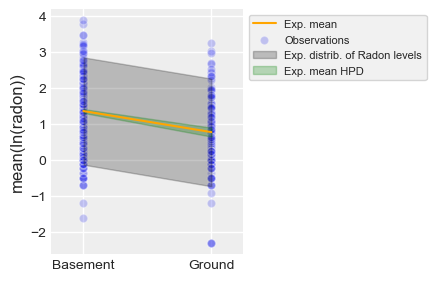

In [38]:
ax = sketch.figure(width=4.25, height=2.7)

complete_.observed_data.plot.scatter(x='LevelCode', y='y', label='Observations', alpha=0.25, ax=ax)

az.plot_hdi(hdi_predictive.levelcode.values, 
            hdi_data=hdi_predictive, 
            fill_kwargs={'alpha': 0.25, 'label': 'Exp. distrib. of Radon levels'}, 
            color='k',
            ax=ax)

az.plot_hdi(hdi_features.LevelCode.values, 
            hdi_data=hdi_features['measures'], 
            fill_kwargs={'alpha': 0.25, 'label': 'Exp. mean HPD'}, 
            color='green',
            ax=ax)

ax.plot(np.arange(averages_features.coords['Level'].shape[0]), 
        averages_features['measures'].values, 
        color='orange',
        label='Exp. mean')

sketch.annotation(ax, Labels(title='', xlabel='', ylabel='mean(ln(radon))'))

ax.set_xlim(-0.25, 1.25)

ax.set_xticks(complete_.posterior['LevelCode'].values)
ax.set_xticklabels(complete_.posterior['Level'].values, rotation=0)

ax.legend(fontsize=8, frameon=True, bbox_to_anchor=(1, 1), loc='upper left')

<br>
<br>

**Clean-up**

In [39]:
del hdi_features, averages_features, hdi_predictive

<br>

### Inference Data

In [40]:
complete_

Inference data with groups:
	> posterior
	> posterior_predictive
	> log_likelihood
	> sample_stats
	> prior
	> prior_predictive
	> observed_data
	> constant_data

<br>
<br>

## Unpooled

<br>

The object `coords` has the set of distinct counties, each has a distinct index; ref. `coords['County']`.  &nbsp; In future use [an appropriate geographic code](https://www.nist.gov/system/files/documents/2021/08/11/FIPSCodesReplacementChart2015.pdf). &nbsp;  Additionally, the data object `excerpt` includes a `countyindex` field, whereby the relevant dictionary is $\rightarrow$ `coords['County']`.

> ```python
logger.info(coords.keys())
logger.info(coords.get('County'))
```


<br>

### Model

In [41]:
unpooled = src.models.unpooled.Unpooled(coords=coords, seed=RANDOM_SEED).exc(data=excerpt)


The county & level groups: (85, 2)
2022-12-01 14:29:20.686


The shape of mu, whereby mu = measures[countyindex, levelcode]: (919,)
2022-12-01 14:29:20.750


y
2022-12-01 14:29:20.774



<br>
<br>

An illustration of model

* Similarly: `pm.model_to_graphviz(unpooled)`

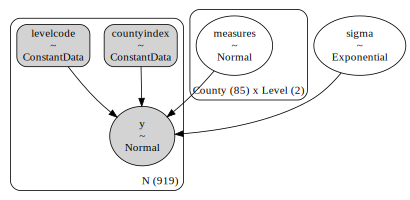

In [42]:
name = 'unpooled.gv'
dag.exc(model=unpooled, name=name)
graphviz.Source.from_file(filename=os.path.join(path, name))

<br>
<br>

### Inference

In [43]:
unpooled_ = src.models.inference.Inference(model=unpooled).exc()

Auto-assigning NUTS sampler...

Auto-assigning NUTS sampler...
2022-12-01 14:29:22.096

Initializing NUTS using jitter+adapt_diag...

Initializing NUTS using jitter+adapt_diag...
2022-12-01 14:29:22.098

Multiprocess sampling (4 chains in 4 jobs)

Multiprocess sampling (4 chains in 4 jobs)
2022-12-01 14:29:25.452

NUTS: [measures, sigma]

NUTS: [measures, sigma]
2022-12-01 14:29:25.453



Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 53 seconds.

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 53 seconds.
2022-12-01 14:30:18.485

Sampling: [measures, sigma, y]

Sampling: [measures, sigma, y]
2022-12-01 14:30:25.320

Sampling: [y]

Sampling: [y]
2022-12-01 14:30:25.500



In [44]:
unpooled_ = src.models.mapping.Mapping(inferences=unpooled_, coords=coords).exc()

In [45]:
unpooled_

Inference data with groups:
	> posterior
	> posterior_predictive
	> log_likelihood
	> sample_stats
	> prior
	> prior_predictive
	> observed_data
	> constant_data

<br>
<br>

### Posterior Measures

<br>

**Posterior Measures & Standard Deviations: Summaries**

In [46]:
az.summary(unpooled_)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
"measures[AITKIN, Basement]",0.677,0.405,-0.098,1.424,0.006,0.005,4546.0,2712.0,1.0
"measures[AITKIN, Ground]",0.815,0.721,-0.560,2.137,0.011,0.009,4091.0,3114.0,1.0
"measures[ANOKA, Basement]",0.955,0.102,0.769,1.151,0.001,0.001,4788.0,2846.0,1.0
"measures[ANOKA, Ground]",-0.131,0.423,-0.920,0.677,0.006,0.007,4764.0,2684.0,1.0
"measures[BECKER, Basement]",1.479,0.721,0.159,2.806,0.012,0.009,3829.0,3140.0,1.0
...,...,...,...,...,...,...,...,...,...
"measures[WRIGHT, Basement]",1.674,0.202,1.299,2.039,0.003,0.002,4676.0,2834.0,1.0
"measures[WRIGHT, Ground]",0.885,0.730,-0.500,2.223,0.011,0.010,4085.0,2473.0,1.0
"measures[YELLOW MEDICINE, Basement]",1.224,0.511,0.227,2.124,0.007,0.006,5138.0,2925.0,1.0
"measures[YELLOW MEDICINE, Ground]",0.122,9.929,-19.490,17.022,0.141,0.164,4938.0,3119.0,1.0


<br>

<br>

**Posterior Measures & Standard Deviations: Graphs**

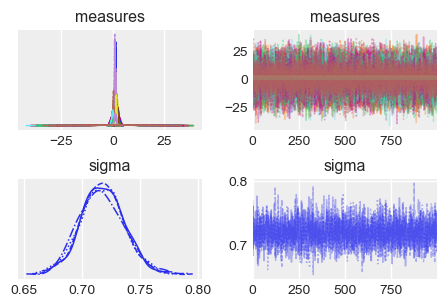

In [47]:
with unpooled:
    az.plot_trace(data=unpooled_, figsize=(4.35, 2.95))

<br>
<br>

**Posterior Measures: High Density Intervals**

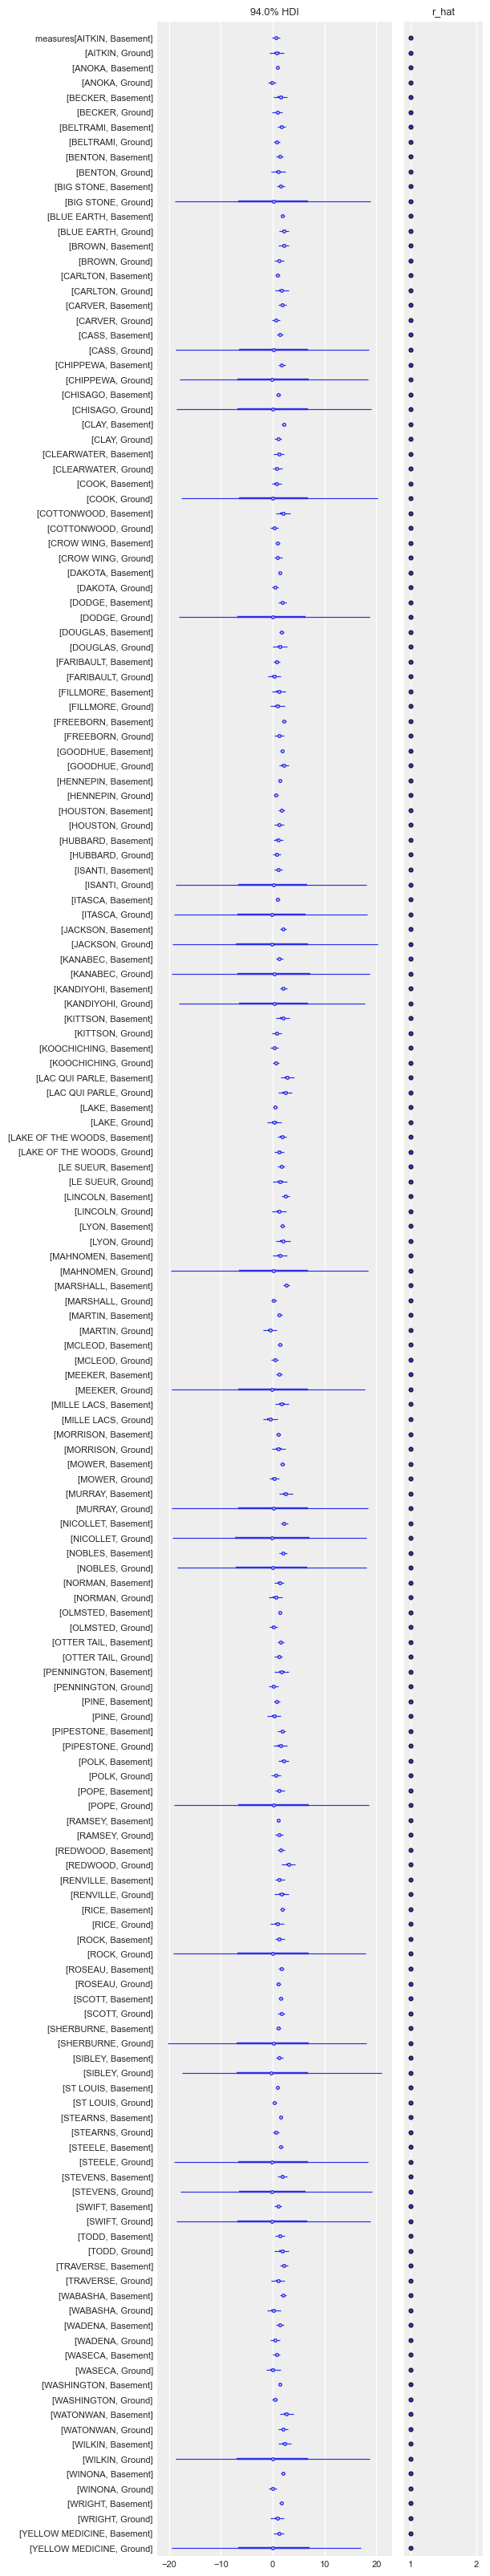

In [48]:
az.plot_forest(
    unpooled_, var_names='measures', figsize=(6, 32), r_hat=True, combined=True, textsize=8
);

<br>

**Posterior Mean**

In [49]:
averages_features = unpooled_.posterior.mean(dim=('chain', 'draw'))
averages_features

<xarray.Dataset>
Dimensions:      (County: 85, Level: 2, LevelCode: 2, CountyIndex: 85)
Coordinates:
  * County       (County) <U17 'AITKIN' 'ANOKA' ... 'WRIGHT' 'YELLOW MEDICINE'
  * Level        (Level) <U8 'Basement' 'Ground'
  * LevelCode    (LevelCode) int32 0 1
  * CountyIndex  (CountyIndex) int32 0 1 2 3 4 5 6 7 ... 77 78 79 80 81 82 83 84
Data variables:
    measures     (County, Level) float64 0.6772 0.8149 0.955 ... 1.224 0.1218
    sigma        float64 0.7178

<br>

**Posterior Check**

In [50]:
hdi_features = az.hdi(unpooled_)
hdi_features

<xarray.Dataset>
Dimensions:      (County: 85, Level: 2, hdi: 2, LevelCode: 2, CountyIndex: 85)
Coordinates:
  * County       (County) <U17 'AITKIN' 'ANOKA' ... 'WRIGHT' 'YELLOW MEDICINE'
  * Level        (Level) <U8 'Basement' 'Ground'
  * LevelCode    (LevelCode) int32 0 1
  * CountyIndex  (CountyIndex) int32 0 1 2 3 4 5 6 7 ... 77 78 79 80 81 82 83 84
  * hdi          (hdi) <U6 'lower' 'higher'
Data variables:
    measures     (County, Level, hdi) float64 -0.09846 1.424 ... -19.49 17.02
    sigma        (hdi) float64 0.6821 0.7539

<br>
<br>

### Graphs

<br>

**High Density Intervals, Averages**

For more about `sel(.)` visit [arviz.InferenceData.sel(.)](https://python.arviz.org/en/latest/api/generated/arviz.InferenceData.sel.html).  &nbsp; The # of counties is

> ```python 
len(coords.get('County'))


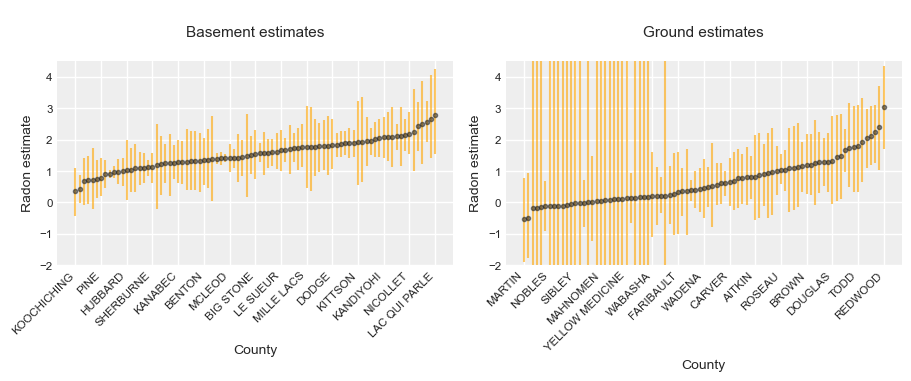

In [51]:
fig, axes = plt.subplots(1, 2, figsize=(9, 3.7))

xticks = np.arange(0, 86, 6)

fontdict = {'horizontalalignment': 'right', 'fontsize': 8}

for ax, level in zip(axes, ['Basement', 'Ground']):
    
    averages_ = averages_features.sel(Level=level).sortby('measures')
    
    # the HDI limits per County ordered by increasing average, i.e., as above
    hdi_ = hdi_features.sel(Level=level).sortby(averages_.measures)
    
    # the scatter plot of the average value per County
    ax.plot(averages_['County'].values, averages_['measures'].values, 'ok', markersize=3, alpha=0.5);
    
    # high density interval lines
    ax.vlines(
        np.arange(len(coords.get('County'))),
        hdi_.measures.sel(hdi='lower'),
        hdi_.measures.sel(hdi='higher'),
        color='orange',
        alpha=0.6,
    )    
    
    # titles
    ax.set_title(f'\n{level.title()} estimates\n', fontsize=11)
    
    # x ticks
    ax.set_xticks(xticks)
    ax.set_xticklabels(averages_.County.values[xticks], horizontalalignment='right', rotation=45)
    
    # all ticks
    ax.tick_params(labelsize='x-small')
    
    # limits
    ax.set_ylim(bottom=-2, top=4.5)
    
    # labels
    ax.set_xlabel('County', fontsize=10)
    ax.set_ylabel('Radon estimate', fontsize=10)
    

<br>
<br>

**Ground Level Dispersions of High Density Intervals**

Ground level posterior `measures`  high density interval data

In [52]:
experiment = hdi_features['measures'].sel(Level='Ground')

<br>

Hence, the differences and their parallel county names

In [53]:
differences = pd.DataFrame(data={'difference': experiment.sel(hdi='higher') - experiment.sel(hdi='lower'), 
                                 'county': experiment['County']})

<br>

Differences and frequencies.

In [54]:
values = frequencies.loc[frequencies['floor'] == coords['Level']['Ground'], ]
dispersions = differences.merge(values, how='left', on='county')
logger.info(dispersions.tail())


    difference           county  countyindex  floor    N
80    1.900324         WATONWAN         80.0    1.0  2.0
81   37.327509           WILKIN          NaN    NaN  NaN
82    1.498258           WINONA         82.0    1.0  3.0
83    2.723348           WRIGHT         83.0    1.0  1.0
84   36.512531  YELLOW MEDICINE          NaN    NaN  NaN
2022-12-01 14:31:00.761



<br>

Some counties do not have any ground level data points

In [55]:
dispersions.loc[:, 'N'] = dispersions['N'].fillna(value=0).array
logger.info(dispersions.tail())


    difference           county  countyindex  floor    N
80    1.900324         WATONWAN         80.0    1.0  2.0
81   37.327509           WILKIN          NaN    NaN  0.0
82    1.498258           WINONA         82.0    1.0  3.0
83    2.723348           WRIGHT         83.0    1.0  1.0
84   36.512531  YELLOW MEDICINE          NaN    NaN  0.0
2022-12-01 14:31:00.773



<br>

The graph below illustrates that the large dispersions, intervals, are due counties that do not have data points.

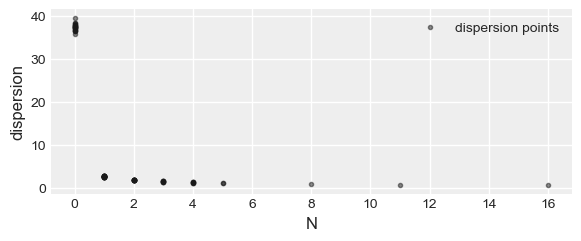

In [56]:
ax = sketch.figure(width=5.7, height=2.3)

ax.plot(dispersions['N'].array, dispersions['difference'].array, 'ok', markersize=3, alpha=0.5, label='dispersion points');
sketch.annotation(ax, Labels(title='', xlabel='N', ylabel='dispersion'))
ax.legend(loc='upper right', fontsize='small');

<br>
<br>

**Funnel**

Upcoming

<br>
<br>

**Estimates**

Upcoming

In [57]:
averages_features['measures'].sel(County='AITKIN')

<xarray.DataArray 'measures' (Level: 2)>
array([0.67720861, 0.81487543])
Coordinates:
    County   <U17 'AITKIN'
  * Level    (Level) <U8 'Basement' 'Ground'

In [58]:
unpooled_.observed_data['y'][unpooled_.observed_data.coords['County'] == 'AITKIN']

<xarray.DataArray 'y' (N: 4)>
array([0.83290912, 1.09861229, 0.09531018, 0.83290912])
Coordinates:
  * N            (N) int32 1 2 3 0
    Level        (N) <U8 'Basement' 'Basement' 'Basement' 'Ground'
    LevelCode    (N) int32 0 0 0 1
    County       (N) <U17 'AITKIN' 'AITKIN' 'AITKIN' 'AITKIN'
    CountyIndex  (N) int32 0 0 0 0

<br>
<br>

**Clean-up**

In [59]:
del hdi_features, hdi_, averages_features, averages_

<br>
<br>

### Inference Data

In [60]:
unpooled_

Inference data with groups:
	> posterior
	> posterior_predictive
	> log_likelihood
	> sample_stats
	> prior
	> prior_predictive
	> observed_data
	> constant_data

<br>
<br>
<br>

## Partial

### Model

In [61]:
partial = src.models.partial.Partial(coords=coords, seed=RANDOM_SEED).exc(data=excerpt)


The shape of mu, whereby mu = intercepts[countyindex]: (919,)
2022-12-01 14:31:02.212


likelihood
2022-12-01 14:31:02.245



<br>

An illustration of model

* Similarly: `pm.model_to_graphviz(partial)`

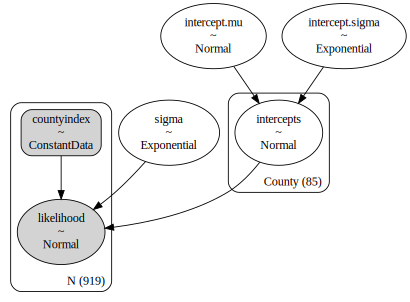

In [62]:
name = 'partial.gv'
dag.exc(model=partial, name=name)
graphviz.Source.from_file(filename=os.path.join(path, name))

<br>
<br>

### Inference

In [63]:
partial_ = src.models.inference.Inference(model=partial).exc()

Auto-assigning NUTS sampler...

Auto-assigning NUTS sampler...
2022-12-01 14:31:04.100

Initializing NUTS using jitter+adapt_diag...

Initializing NUTS using jitter+adapt_diag...
2022-12-01 14:31:04.103

Multiprocess sampling (4 chains in 4 jobs)

Multiprocess sampling (4 chains in 4 jobs)
2022-12-01 14:31:08.607

NUTS: [intercept.mu, intercept.sigma, intercepts, sigma]

NUTS: [intercept.mu, intercept.sigma, intercepts, sigma]
2022-12-01 14:31:08.609



Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 39 seconds.

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 39 seconds.
2022-12-01 14:31:48.256

Sampling: [intercept.mu, intercept.sigma, intercepts, likelihood, sigma]

Sampling: [intercept.mu, intercept.sigma, intercepts, likelihood, sigma]
2022-12-01 14:31:54.812

Sampling: [likelihood]

Sampling: [likelihood]
2022-12-01 14:31:55.008



In [64]:
partial_

Inference data with groups:
	> posterior
	> posterior_predictive
	> log_likelihood
	> sample_stats
	> prior
	> prior_predictive
	> observed_data
	> constant_data

<br>

Enrich

In [65]:
partial_ = src.models.mapping.Mapping(inferences=partial_, coords=coords).exc()

In [66]:
partial_

Inference data with groups:
	> posterior
	> posterior_predictive
	> log_likelihood
	> sample_stats
	> prior
	> prior_predictive
	> observed_data
	> constant_data

<br>
<br>

### Posterior Measures

<br>

**Preliminaries**

The frequencies

In [67]:
logger.info(frequencies.head())


   county  countyindex  floor   N
0  AITKIN            0      0   3
1  AITKIN            0      1   1
2   ANOKA            1      0  49
3   ANOKA            1      1   3
4  BECKER            2      0   1
2022-12-01 14:31:56.331



<br>

Tallies by county only.

In [68]:
T = frequencies.groupby(by=['county', 'countyindex']).agg(N=('N', sum))
T.reset_index(drop=False, inplace=True)
K = T.copy().set_index(keys='countyindex')

logger.info(T.tail())
logger.info(K.tail())


             county  countyindex   N
80         WATONWAN           80   3
81           WILKIN           81   1
82           WINONA           82  13
83           WRIGHT           83  13
84  YELLOW MEDICINE           84   2
2022-12-01 14:31:56.358


                      county   N
countyindex                     
80                  WATONWAN   3
81                    WILKIN   1
82                    WINONA  13
83                    WRIGHT  13
84           YELLOW MEDICINE   2
2022-12-01 14:31:56.362



<br>

Extra co${\ddot{o}}$rdinates



> ```python 
indices[-5:]


In [69]:
indices = partial_.posterior.coords['CountyIndex'].values

In [70]:
partial_.posterior = partial_.posterior.assign_coords({'Tally': ('County', K.iloc[indices, :]['N'].array)})

In [71]:
partial_

Inference data with groups:
	> posterior
	> posterior_predictive
	> log_likelihood
	> sample_stats
	> prior
	> prior_predictive
	> observed_data
	> constant_data

<br>

**Posterior Mean**

In [72]:
averages_features = partial_.posterior.mean(dim=('chain', 'draw'))
averages_features

<xarray.Dataset>
Dimensions:          (County: 85, CountyIndex: 85)
Coordinates:
  * County           (County) <U17 'AITKIN' 'ANOKA' ... 'YELLOW MEDICINE'
  * CountyIndex      (CountyIndex) int32 0 1 2 3 4 5 6 ... 78 79 80 81 82 83 84
    Tally            (County) int64 4 52 3 7 4 3 14 4 10 ... 5 4 46 3 1 13 13 2
Data variables:
    intercept.mu     float64 1.348
    intercepts       (County) float64 1.103 0.946 1.265 ... 1.446 1.526 1.318
    intercept.sigma  float64 0.303
    sigma            float64 0.7671

<br>

**Posterior Check**

In [73]:
hdi_features = az.hdi(partial_)
hdi_features

<xarray.Dataset>
Dimensions:          (hdi: 2, County: 85, CountyIndex: 85)
Coordinates:
  * County           (County) <U17 'AITKIN' 'ANOKA' ... 'YELLOW MEDICINE'
  * CountyIndex      (CountyIndex) int32 0 1 2 3 4 5 6 ... 78 79 80 81 82 83 84
    Tally            (County) int64 4 52 3 7 4 3 14 4 10 ... 5 4 46 3 1 13 13 2
  * hdi              (hdi) <U6 'lower' 'higher'
Data variables:
    intercept.mu     (hdi) float64 1.258 1.434
    intercepts       (County, hdi) float64 0.6619 1.561 0.7582 ... 0.797 1.827
    intercept.sigma  (hdi) float64 0.2191 0.3958
    sigma            (hdi) float64 0.7309 0.8036

<br>
<br>

### Graphs

<br>

**High Density Intervals, Averages,Tallies**

County tally, posterior mean, and high density interval.  `Either`

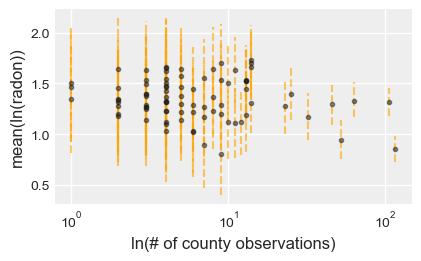

In [74]:
ax = sketch.figure(width=4.1, height=2.5)

# scatter plot
ax.plot(averages_features.coords['Tally'].values, averages_features['intercepts'].values, 'ok', markersize=3, alpha=0.5);

# high density interval lines
ax.vlines(
    hdi_features.coords['Tally'].values,
    hdi_features['intercepts'].sel(hdi='lower').values,
    hdi_features['intercepts'].sel(hdi='higher').values,
    color='orange',
    linestyles='dashed',
    alpha=0.6,
)

# logarithmic scale
ax.set(xscale='log')

# annotations
sketch.annotation(ax, Labels(title='', xlabel='ln(# of county observations)', ylabel='mean(ln(radon))'))

<br>

`Or`

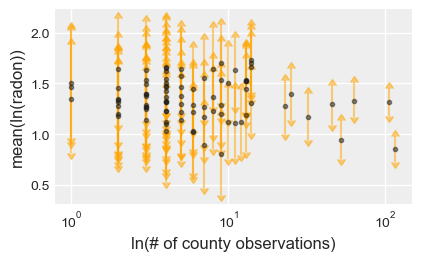

In [75]:
ax = sketch.figure(width=4.1, height=2.5)

# limits
X = np.concatenate((np.expand_dims(hdi_features['intercepts'].sel(hdi='lower').values, axis=0),
                    np.expand_dims(hdi_features['intercepts'].sel(hdi='higher').values, axis=0)))

points = averages_features['intercepts'].values
Y = np.concatenate((np.expand_dims(points - hdi_features['intercepts'].sel(hdi='lower').values, axis=0),
                    np.expand_dims(hdi_features['intercepts'].sel(hdi='higher').values - points, axis=0)))

# graph
ax.errorbar(averages_features.coords['Tally'].values, 
            averages_features['intercepts'].values, 
            Y, 
            uplims=True, lolims=True,
            ecolor='orange', 
            marker='o', markersize=3, markerfacecolor='k', markeredgecolor='k', 
            linestyle='',
            alpha=0.5)

# logarithmic scale
ax.set(xscale='log')

# annotations
sketch.annotation(ax, Labels(title='', xlabel='ln(# of county observations)', ylabel='mean(ln(radon))'))

<br>
<br>

**Clean-up**

In [76]:
del X, Y, hdi_features, averages_features

<br>
<br>

### Inference Data

In [77]:
partial_

Inference data with groups:
	> posterior
	> posterior_predictive
	> log_likelihood
	> sample_stats
	> prior
	> prior_predictive
	> observed_data
	> constant_data

<br>
<br>
<br>

## Varying Intercept

### Model

In [78]:
vi = src.models.vi.VI(coords=coords, seed=RANDOM_SEED).exc(data=excerpt)


The shape of mu, whereby mu = intercepts[countyindex] + (beta * levelcode): (919,)
2022-12-01 14:32:03.431


likelihood
2022-12-01 14:32:03.450



<br>

An illustration of model

* Similarly: `pm.model_to_graphviz(vi)`

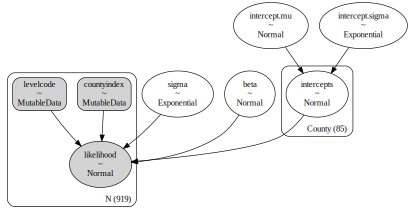

In [79]:
name = 'vi.gv'
dag.exc(model=vi, name=name)
graphviz.Source.from_file(filename=os.path.join(path, name))

<br>
<br>

### Inference

In [80]:
vi_ = src.models.inference.Inference(model=vi).exc()

Auto-assigning NUTS sampler...

Auto-assigning NUTS sampler...
2022-12-01 14:32:05.429

Initializing NUTS using jitter+adapt_diag...

Initializing NUTS using jitter+adapt_diag...
2022-12-01 14:32:05.431

Multiprocess sampling (4 chains in 4 jobs)

Multiprocess sampling (4 chains in 4 jobs)
2022-12-01 14:32:10.582

NUTS: [intercept.mu, intercept.sigma, intercepts, beta, sigma]

NUTS: [intercept.mu, intercept.sigma, intercepts, beta, sigma]
2022-12-01 14:32:10.584



Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 41 seconds.

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 41 seconds.
2022-12-01 14:32:52.139

Sampling: [beta, intercept.mu, intercept.sigma, intercepts, likelihood, sigma]

Sampling: [beta, intercept.mu, intercept.sigma, intercepts, likelihood, sigma]
2022-12-01 14:32:59.184

Sampling: [likelihood]

Sampling: [likelihood]
2022-12-01 14:32:59.432



In [81]:
vi_

Inference data with groups:
	> posterior
	> posterior_predictive
	> log_likelihood
	> sample_stats
	> prior
	> prior_predictive
	> observed_data
	> constant_data